In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import ftfy
import os
import pandas as pd


# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "dbd.puc-rio.br"
full_url = "https://www.dbd.puc-rio.br/"
site_path = "/sitenovo"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        print("link: " + link)
        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
             
            clean_link = "https://" + local_domain + "/" + link            

        
        if clean_link is not None:
            print("clean_link: " + clean_link)
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc + site_path

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)



In [ ]:
crawl(full_url)

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('\t', ' ')
    serie = serie.str.replace('\r', ' ')
    new_serie = []
    for row in serie:
        row = ftfy.fix_encoding(row)
        new_serie.append(row)

    return new_serie

In [7]:

# Create a list to store the text files
texts=[]
ids = []
urls = []
sources = []
titles = []
i = 1
# Get all the text files in the text directory
for file in os.listdir("text/" + domain + site_path + "/"):
    # Open the file and read the text
    with open("text/" + domain + site_path + "/" + file, "r") as f:
        text = f.read()

        # get the page name(dbd exclusive formula!)
        # www.dbd.puc-rio.br_sitenovo__area-restrita.php.txt
        start_index = file.rindex('_') + 1
        end_index = file.index('.', start_index)        
        fname = file[start_index:end_index]
        if(fname == ""):
            fname = "home"

        url = file
        
        source = domain + site_path

        ids.append(str(i))
        urls.append(url)
        sources.append(source)
        titles.append(fname)
        texts.append(text)        
        
        i += 1

# Create a dataframe from the list of texts
df = pd.DataFrame(list(zip(ids, titles, sources, urls, texts)), columns = ['id', 'title', 'source', 'url', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.title + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv', index=False, header=True)
df.tail(50)

/tmp/ipykernel_1187/1741227447.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,id,title,source,url,text
33,34,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
34,35,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
35,36,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
36,37,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
37,38,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
38,39,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
39,40,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
40,41,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
41,42,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...
42,43,destaques,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_destaques.html#des...,destaques. Destaques DBD PUC-Rio pesq...


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [50]:
df['text'].to_csv('text.csv', index=False, header=True)

<AxesSubplot: >

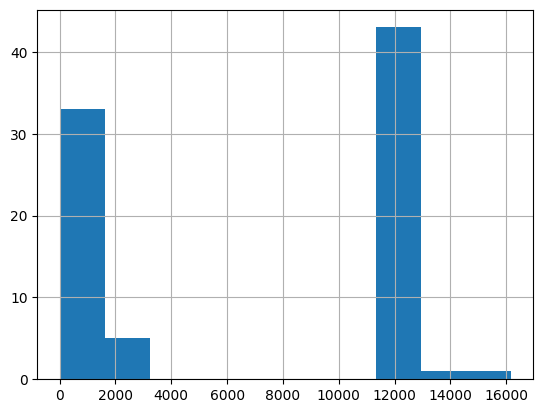

In [8]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv')
df.columns = ['id', 'title', 'source', 'url', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [9]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []
ids = []
titles = []
sources = [] 
urls = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue
    
    
    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        short_texts = split_into_many(row[1]['text'])     
        shortened += short_texts
    
    # Otherwise, add the text to the list of shortened texts
    else:
        short_texts = [row[1]['text']]
        shortened.append( short_texts[0] )
    
    for short_text in short_texts:
        ids.append(row[1]['id'])
        titles.append(row[1]['title'])
        sources.append(row[1]['source'])
        urls.append(row[1]['url'])
    


In [11]:
len(shortened)

1261

<AxesSubplot: >

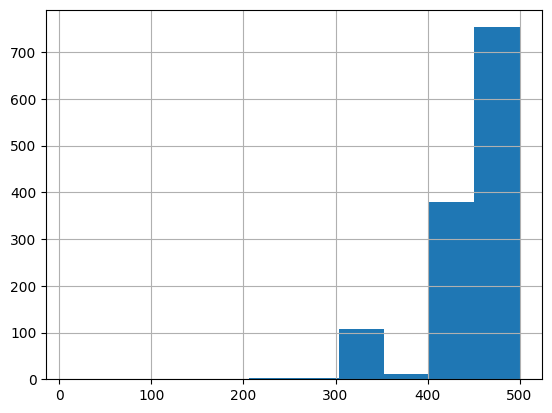

In [12]:
df = pd.DataFrame(list(zip(ids, titles, sources, urls, shortened)), columns = ['id', 'title', 'source', 'url', 'text'])

#df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [64]:
len(ids)

1261

In [13]:
df

,id,title,source,url,text,n_tokens
0,1,brasil500anos,dbd.puc-rio.br/sitenovo,ww.dbd.puc-rio.br_brasil500anos_brasil500anos....,brasil500anos. PUC-RIO - DBD - Brasil 500 Ano...,117
1,2,libris,dbd.puc-rio.br/sitenovo,ww.dbd.puc-rio.br_ex-libris_pg_index_libris.ht...,libris. EX-LIBRIS,10
2,3,home,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_.txt,home. ﻿ DBD PUC RIO DBD PUC-Rio pesq...,346
3,3,home,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_.txt,destaques grupo 01 de 02 grupo 02 de 02 Inform...,485
4,4,exposicoes-virtuais,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_exposicoes-virtuais.html.txt,exposicoes-virtuais. Exposições Virtuais D...,500
...,...,...,...,...,...,...
1256,81,versao-mobile,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_versao-mobile.html...,versao-mobile. Versão Mobile DBD PUC...,487
1257,81,versao-mobile,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_versao-mobile.html...,Renovação É possível renovar o prazo dos livro...,348
1258,82,visitantes,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_visitantes.html.txt,visitantes. Visitantes DBD PUC-Rio p...,426
1259,82,visitantes,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_visitantes.html.txt,Para isso é necessário informar: o númer...,466


In [65]:
df['index'] = df.index

In [66]:
df

,id,title,source,url,text,n_tokens,embeddings,index
0,1,brasil500anos,dbd.puc-rio.br/sitenovo,ww.dbd.puc-rio.br_brasil500anos_brasil500anos....,brasil500anos. PUC-RIO - DBD - Brasil 500 Ano...,117,"{'object': 'embedding', 'index': 0, 'embedding...",0
1,2,libris,dbd.puc-rio.br/sitenovo,ww.dbd.puc-rio.br_ex-libris_pg_index_libris.ht...,libris. EX-LIBRIS,10,"{'object': 'embedding', 'index': 0, 'embedding...",1
2,3,home,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_.txt,home. ﻿ DBD PUC RIO DBD PUC-Rio pesq...,346,"{'object': 'embedding', 'index': 0, 'embedding...",2
3,3,home,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_.txt,destaques grupo 01 de 02 grupo 02 de 02 Inform...,485,"{'object': 'embedding', 'index': 0, 'embedding...",3
4,4,exposicoes-virtuais,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_exposicoes-virtuais.html.txt,exposicoes-virtuais. Exposições Virtuais D...,500,"{'object': 'embedding', 'index': 0, 'embedding...",4
...,...,...,...,...,...,...,...,...
1256,81,versao-mobile,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_versao-mobile.html...,versao-mobile. Versão Mobile DBD PUC...,487,"{'object': 'embedding', 'index': 0, 'embedding...",1256
1257,81,versao-mobile,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_versao-mobile.html...,Renovação É possível renovar o prazo dos livro...,348,"{'object': 'embedding', 'index': 0, 'embedding...",1257
1258,82,visitantes,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_visitantes.html.txt,visitantes. Visitantes DBD PUC-Rio p...,426,"{'object': 'embedding', 'index': 0, 'embedding...",1258
1259,82,visitantes,dbd.puc-rio.br/sitenovo,www.dbd.puc-rio.br_sitenovo_visitantes.html.txt,Para isso é necessário informar: o númer...,466,"{'object': 'embedding', 'index': 0, 'embedding...",1259


In [141]:
len(df['text'].values[5])

1308

In [12]:
# imports
import time
import openai

# Define a function that adds a delay to a Embedding API call
def delayed_embedding(delay_in_seconds: float = 1, **kwargs):
    """Delay a completion by a specified amount of time."""

    # Sleep for the delay
    time.sleep(delay_in_seconds)

    # Call the Embeeding API and return the result
    #return openai.Completion.create(**kwargs)
    return openai.Embedding.create(**kwargs)['data'][0]['embedding']




In [14]:
# Define a function that adds a delay to a Completion API call
def delayed_completion(delay_in_seconds: float = 1, **kwargs):
    """Delay a completion by a specified amount of time."""

    # Sleep for the delay
    time.sleep(delay_in_seconds)

    # Call the Completion API and return the result
    return openai.Completion.create(**kwargs)


# Calculate the delay based on your rate limit
#rate_limit_per_minute = 20
#delay = 60.0 / rate_limit_per_minute

#delayed_completion(
#    delay_in_seconds=delay,
#    model="text-davinci-002",
#    prompt="Once upon a time,"
#)


# Vector Database Implementation

# Pinecone Upsert

In [77]:
# get embeddings vector dimension
res = openai.Embedding.create(
    input=[
        "Sample document text goes here",
        "there will be several phrases in each batch"
    ], engine=embed_model
)

vector_dimension = len(res['data'][0]['embedding'])
vector_dimension

1536

In [18]:
import pinecone
from dotenv import load_dotenv


def configure_pinecone(index_name, create_index=False):
  
    load_dotenv()

    PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

    openai.api_key = OPENAI_API_KEY

    # initialize connection to pinecone (get API key at app.pinecone.io)
    pinecone.init(
        api_key=PINECONE_API_KEY,
        environment="us-west1-gcp"  # may be different, check at app.pinecone.io
    )

    # get embeddings vector dimension
    res = openai.Embedding.create(
        input=[
            "Sample document text goes here",
            "there will be several phrases in each batch"
        ], engine=embed_model
    )

    vector_dimension = len(res['data'][0]['embedding'])

    # check if index already exists (it shouldn't if this is first time)
    if(create_index):
        if index_name not in pinecone.list_indexes():
            # if does not exist, create index
            pinecone.create_index(
                index_name,
                dimension=vector_dimension,
                metric='cosine',
                metadata_config={'indexed': ['channel_id', 'published']}
            )
    # connect to index
    index = pinecone.Index(index_name)
    # view index stats
    index.describe_index_stats()
    return index

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1261 non-null   object
 1   title       1261 non-null   object
 2   source      1261 non-null   object
 3   url         1261 non-null   object
 4   text        1261 non-null   object
 5   n_tokens    1261 non-null   object
 6   embeddings  1261 non-null   object
 7   index       1261 non-null   object
dtypes: object(8)
memory usage: 78.9+ KB


In [77]:
df = df.applymap(str)

In [5]:
from tqdm.auto import tqdm
import datetime
from time import sleep

import openai
from dotenv import load_dotenv

index_name = 'openai-dbd-website'
embed_model = 'text-embedding-ada-002'

def pinecone_upsert(new_data, create_index=False):
  
  print('New Data Lenght: ', len(new_data))
  
  load_dotenv()

  OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

  openai.api_key = OPENAI_API_KEY

  # create the index on pinecone
  pinecone_index = configure_pinecone(index_name, create_index)
  
  # Calculate the delay based on your rate limit
  rate_limit_per_minute = 12
  delay = 60.0 / rate_limit_per_minute
  
  batch_size = 1  # how many embeddings we create and insert at once
  
  all_embeds = []

  for i in tqdm(range(0, len(new_data), batch_size)):
      # find end of batch
      i_end = min(len(new_data), i+batch_size)

      meta_batch = new_data[i:i_end]

      print('processing batch: ', str(i), '-', str(i_end))
      
      # get ids
      ids_batch = []
      for index, row in meta_batch.iterrows():
          ids_batch.append(row['index'])

      # get texts to encode
      texts = []
      for index, row in meta_batch.iterrows():
          texts.append(row['text'])
      
      print(texts)

      # create embeddings (try-except added to avoid RateLimitError)      
      try:
          print('attempting to create embeddings : ', str(i), '-', str(i_end))
          res = openai.Embedding.create(input=texts, engine=embed_model)
      except:
          done = False
          while not done:
              print('sleeping to prevent rate limit error: ', str(i), '-', str(i_end))
              sleep(5)              
              try:
                  res = openai.Embedding.create(input=texts, engine=embed_model)
                  done = True
              except:
                  pass
      
      print('embeddings created: ', str(i), '-', str(i_end))
      
      batch_embeds = []

      for embed in res['data']:
        batch_embeds.append(embed['embedding'])
        all_embeds.append(embed)
        
      # cleanup metadata
      meta_batches = []
      for index, row in meta_batch.iterrows():
        meta_batches.append({
          'id': row['id'],
          'title': row['title'],
          'text': row['text'],
          'url': row['url'],
          'source': row['source']
        })
      
      to_upsert = list(zip(ids_batch, batch_embeds, meta_batches))
      
      #print(to_upsert)
      # upsert to Pinecone
      pinecone_index.upsert(vectors=to_upsert)

      print('vectors upserted: ', str(i), '-', str(i_end))

  new_data['embeddings'] = all_embeds
  new_data.to_csv('processed/embeddings.csv')
  new_data.head()
  
  return index

In [80]:

# Upsert all the dataframe embeddings to pinecone with metadata included
pinecone_index = pinecone_upsert(df, create_index=False)


New Data Lenght:  1261


  0%|          | 0/1261 [00:00<?, ?it/s]

processing batch:  0 - 1
['brasil500anos.  PUC-RIO - DBD - Brasil 500 Anos      Comemorando os 500    anos do descobrimento do Brasil, a Divisão de    Bibliotecas e Documentação da PUC-RIO    apresenta, através desta exposição virtual,    uma seleção de obras raras de seu acervo,    relacionadas ao descobrimento do Brasil. A   curadoria é de Elizeu de Araujo Lima, pesquisador   e especialista em obras raras.       ']
attempting to create embeddings :  0 - 1
embeddings created:  0 - 1
vectors upserted:  0 - 1
processing batch:  1 - 2
['libris.  EX-LIBRIS  ']
attempting to create embeddings :  1 - 2
embeddings created:  1 - 2
vectors upserted:  1 - 2
processing batch:  2 - 3
['home. \ufeff  DBD PUC RIO    DBD\xa0      PUC-Rio pesquisa integrada    \xa0        somente itens da biblioteca catálogo livre autor título assunto ? Busque em: catálogo das Bibliotecas PUC-Rio, Projeto Maxwell, Portal CAPES, e-Books, Periódicos Eletrônicos, entre outras fontes.      Conteúdo completo, fora do camp

# Pinecone Retrieve

In [10]:
limit = 3750

def pinecone_retrieve(query, limit):
    res = openai.Embedding.create(
        input=[query],
        engine="text-embedding-ada-002"
    )

    # retrieve from Pinecone
    xq = res['data'][0]['embedding']

    # get relevant contexts
    res = pinecone_index.query(xq, top_k=5, include_metadata=True)
    contexts = [
        x['metadata']['text'] for x in res['matches']
    ]

    # build our prompt with the retrieved contexts included
    prompt_start = (
        "Responda a Pergunta baseado no contexto abaixo. Seja Simpática, perspicaz, com um leve toque de humor e acrescente mais informações a sua resposta do que somente a resposta em si. No final pergunte se pode ajudar o usuario com mais alguma coisa, variando essa sentença a cada vez que falar com ele para outras similares. Se não for possível idenificar a resposta no contexto enviado, responda educadamente que não sabe a resposta exata para essa pergunta.\n\n"+
        "Contexto:\n"
    )
    prompt_end = (
        f"\n\nPergunta: {query}\nResposta:"
    )
    # append contexts until hitting limit
    for i in range(0, len(contexts)):
        if len("\n\n---\n\n".join(contexts[:i])) >= limit:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts[:i-1]) +
                prompt_end
            )
            break
        elif i == len(contexts)-1:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts) +
                prompt_end
            )
    return prompt

In [7]:
def openai_complete(prompt):
    # query text-davinci-003
    res = openai.Completion.create(
        engine='text-davinci-003',
        prompt=prompt,
        temperature=1,
        max_tokens=1000,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return res['choices'][0]['text'].strip()

In [8]:
def answer_question(question,debug=False):

    limit = 3750

    prompt = pinecone_retrieve(query=query, limit=limit)
    
    answer = openai_complete(prompt)

    # If debug, print the raw model response
    if debug:
        print("Prompt:\n" + prompt)
        print("\n\n")

    return answer

In [19]:
# connect to index
pinecone_index = configure_pinecone(index_name,create_index=False)
# view index stats
pinecone_index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1261}},
 'total_vector_count': 1261}

In [34]:
query = "Qual horario de funcionamento da biblioteca do CTC?"

answer = answer_question(query, debug=True)

print(answer)

Prompt:
Responda a Pergunta baseado no contexto abaixo. Seja Simpática, perspicaz, com um leve toque de humor e acrescente mais informações a sua resposta do que somente a resposta em si. No final pergunte se pode ajudar o usuario com mais alguma coisa, variando essa sentença a cada vez que falar com ele para outras similares. Se não for possível idenificar a resposta no contexto enviado, responda educadamente que não sabe a resposta exata para essa pergunta.

Contexto:
a 6a.feira, de 8h30 às 19h                Não funciona aos sábados                BIBLIOTECA SETORIAL DO CTC (BS/CTC)                2ª a 6ª feira, de 8h30 às 17h                04/01 a 26/01- BS/CTC Fechada para Reforma          No Ar - Sites Selecionados Qui, 09/11/2017 Confira a lista, de sites selecionados (nacionais e internacionais) em diversas áreas de conhecimento e de interesse geral.        Mais uma fonte de informações para seus estudos e pesquisa Confira  Novo Post no nosso Blog Qui, 26/10/2017 A Divisão de 

BIBLIOTECA SETORIAL DO CENTRO TÉCNICO CIENTÍFICO (BS/CTC)


A Biblioteca Setorial do Centro Técnico Científico (BS/CTC), localizada no 7º andar do Ed. Cardeal Leme, disponibiliza amplas salas de estudo em grupo (168 lugares) e individual (73 lugares).

Horário:
Período Letivo - de 2ª a 6ª , de 8h30 às 19h
Férias - Fechada.

Para mais informações contate diretamente a Biblioteca através do e-mail bcentral@dbd.puc-rio.br

Como faço para doar livros à Biblioteca?
O Sistema de Bibliotecas aceita doações de livros e material bibliográfico, entretanto é necessário enviar à Seção de Desenvolvimento de Coleções e Aquisição (DCOL), uma relação dos itens que deseja doar, contendo autor/título/ano, para uma pré-seleção.
Após o aceite, os doadores deverão assinar o "Formulário de Doação", concordando que o material seja acervado de acordo com a política de seleção e tratamento técnico do Sistema de Bibliotecas ou que os mesmos sejam repassados para outra instituição e/ou usuário, caso não sejam relevantes à comunidade acadêmica da PUC-Rio.

In [22]:
query = "Quem é a Bia?"

res = openai.Embedding.create(
        input=[query],
        engine="text-embedding-ada-002"
    )

# retrieve from Pinecone
xq = res['data'][0]['embedding']

# get relevant contexts
res = pinecone_index.query(xq, top_k=5, include_metadata=True)
contexts = [
    x['metadata']['text'] for x in res['matches']
]

res

{'matches': [{'id': '896',
              'metadata': {'id': '51',
                           'source': 'dbd.puc-rio.br/sitenovo',
                           'text': 'a 6a.feira, de 8h30 às 19h                '
                                   'Não funciona aos sábados                '
                                   'BIBLIOTECA SETORIAL DO CTC '
                                   '(BS/CTC)                2ª a 6ª feira, de '
                                   '8h30 às 17h                04/01 a 26/01- '
                                   'BS/CTC Fechada para Reforma          No Ar '
                                   '- Sites Selecionados Qui, 09/11/2017 '
                                   'Confira a lista, de sites selecionados '
                                   '(nacionais e internacionais) em diversas '
                                   'áreas de conhecimento e de interesse '
                                   'geral.        Mais uma fonte de '
                              

# Memory Based Implementation

In [31]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,blog authors maddie. Maddie Hall - OpenAI ...,175,"[-0.012958061881363392, -0.006103983614593744,..."
1,blog authors tom. Tom Brown - OpenAI ...,228,"[-0.0053874170407652855, -0.009962032549083233..."
2,blog openai scholars 2019 final projects. Op...,492,"[0.0019150723237544298, -0.0070442273281514645..."
3,"In this project, I used curiosity-driven explo...",478,"[-0.0067560747265815735, 0.0004431474662851542..."
4,Results revealed that the optimal RL policies ...,499,"[-0.012868616729974747, 0.0029640409629791975,..."


In [32]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

'No, you are not allowed to publish model outputs to Twitter without a human review. You must manually review each generation before sharing or while streaming, and indicate that the content is AI-generated in a way no user could reasonably miss or misunderstand.'

In [33]:
answer_question(df, question="What day is it?", debug=False)

"I don't know."

In [34]:
answer_question(df, question="What is our newest embeddings model?")

'The newest embeddings model is text-embedding-ada-002.'